In [1]:
import numpy as np
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

from numba import cuda

from geotiff import GeoTiff
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import geopandas as gdp

In [55]:
ores = {
    'Iron': 'Iron',
    'Lead': 'Lead',
    'Salt': 'Salt',
    #'Aluminum': 'Aluminum',
    'Gold': 'Gold',
    'Sulfur-Pyrite': 'Sulfur',
    'Silver': 'Silver',
    'Sulfur': 'Sulfur',
    'Copper': 'Copper',
    'Tin': 'Tin',
    'Diamond': 'Gemstones',
    #'Uranium': 'Uranium',
    'Mercury': 'Mercury',
    'Gemstone': 'Gemstones',
    'Coal': 'Coal',
    'Lignite': 'Coal',
    #'Petroleum (Oil)': 'Oil',
    'Sulfides': 'Sulfur',
    'Semiprecious Gemstone': 'Gemstones',
    'Sulfuric Acid': 'Sulfur',
    'Anthracite': 'Coal',
    'Sapphire': 'Gemstones',
    'Jade': 'Gemstones',
    'Emerald': 'Gemstones',
    'Pyrite': 'Sulfur',
    'Ruby': 'Gemstones'
}

In [85]:
mining = pd.read_csv('inputs/mining/data.csv', delimiter=';')
mining = mining[mining['lat']>-60]
mining = mining[mining['lat']<70]
mining['res1'] = mining['res1'].apply(lambda x: x.split(', ') if type(x)==str else [])
mining['res2'] = mining['res2'].apply(lambda x: x.split(', ') if type(x)==str else [])
mining['res3'] = mining['res3'].apply(lambda x: x.split(', ') if type(x)==str else [])
mining['resource'] = mining.apply(lambda x: x['res1']+x['res2']+x['res3'], axis=1)
mining.drop(['res1','res2','res3'], axis=1, inplace=True)
mining = mining.explode('resource')
mining['resource'] = mining['resource'].apply(lambda x: ores[x] if x in ores else 'Other')
mining = mining[mining['resource']!='Other']

mining.head()

,lat,lon,Producer type,resource
2,0.00160,-78.54979,Occurrence,Lead
5,-0.01511,-78.81649,Prospect,Gold
7,0.01937,-78.54729,Occurrence,Lead
8,-0.02063,115.45167,Prospect,Gold
8,-0.02063,115.45167,Prospect,Silver


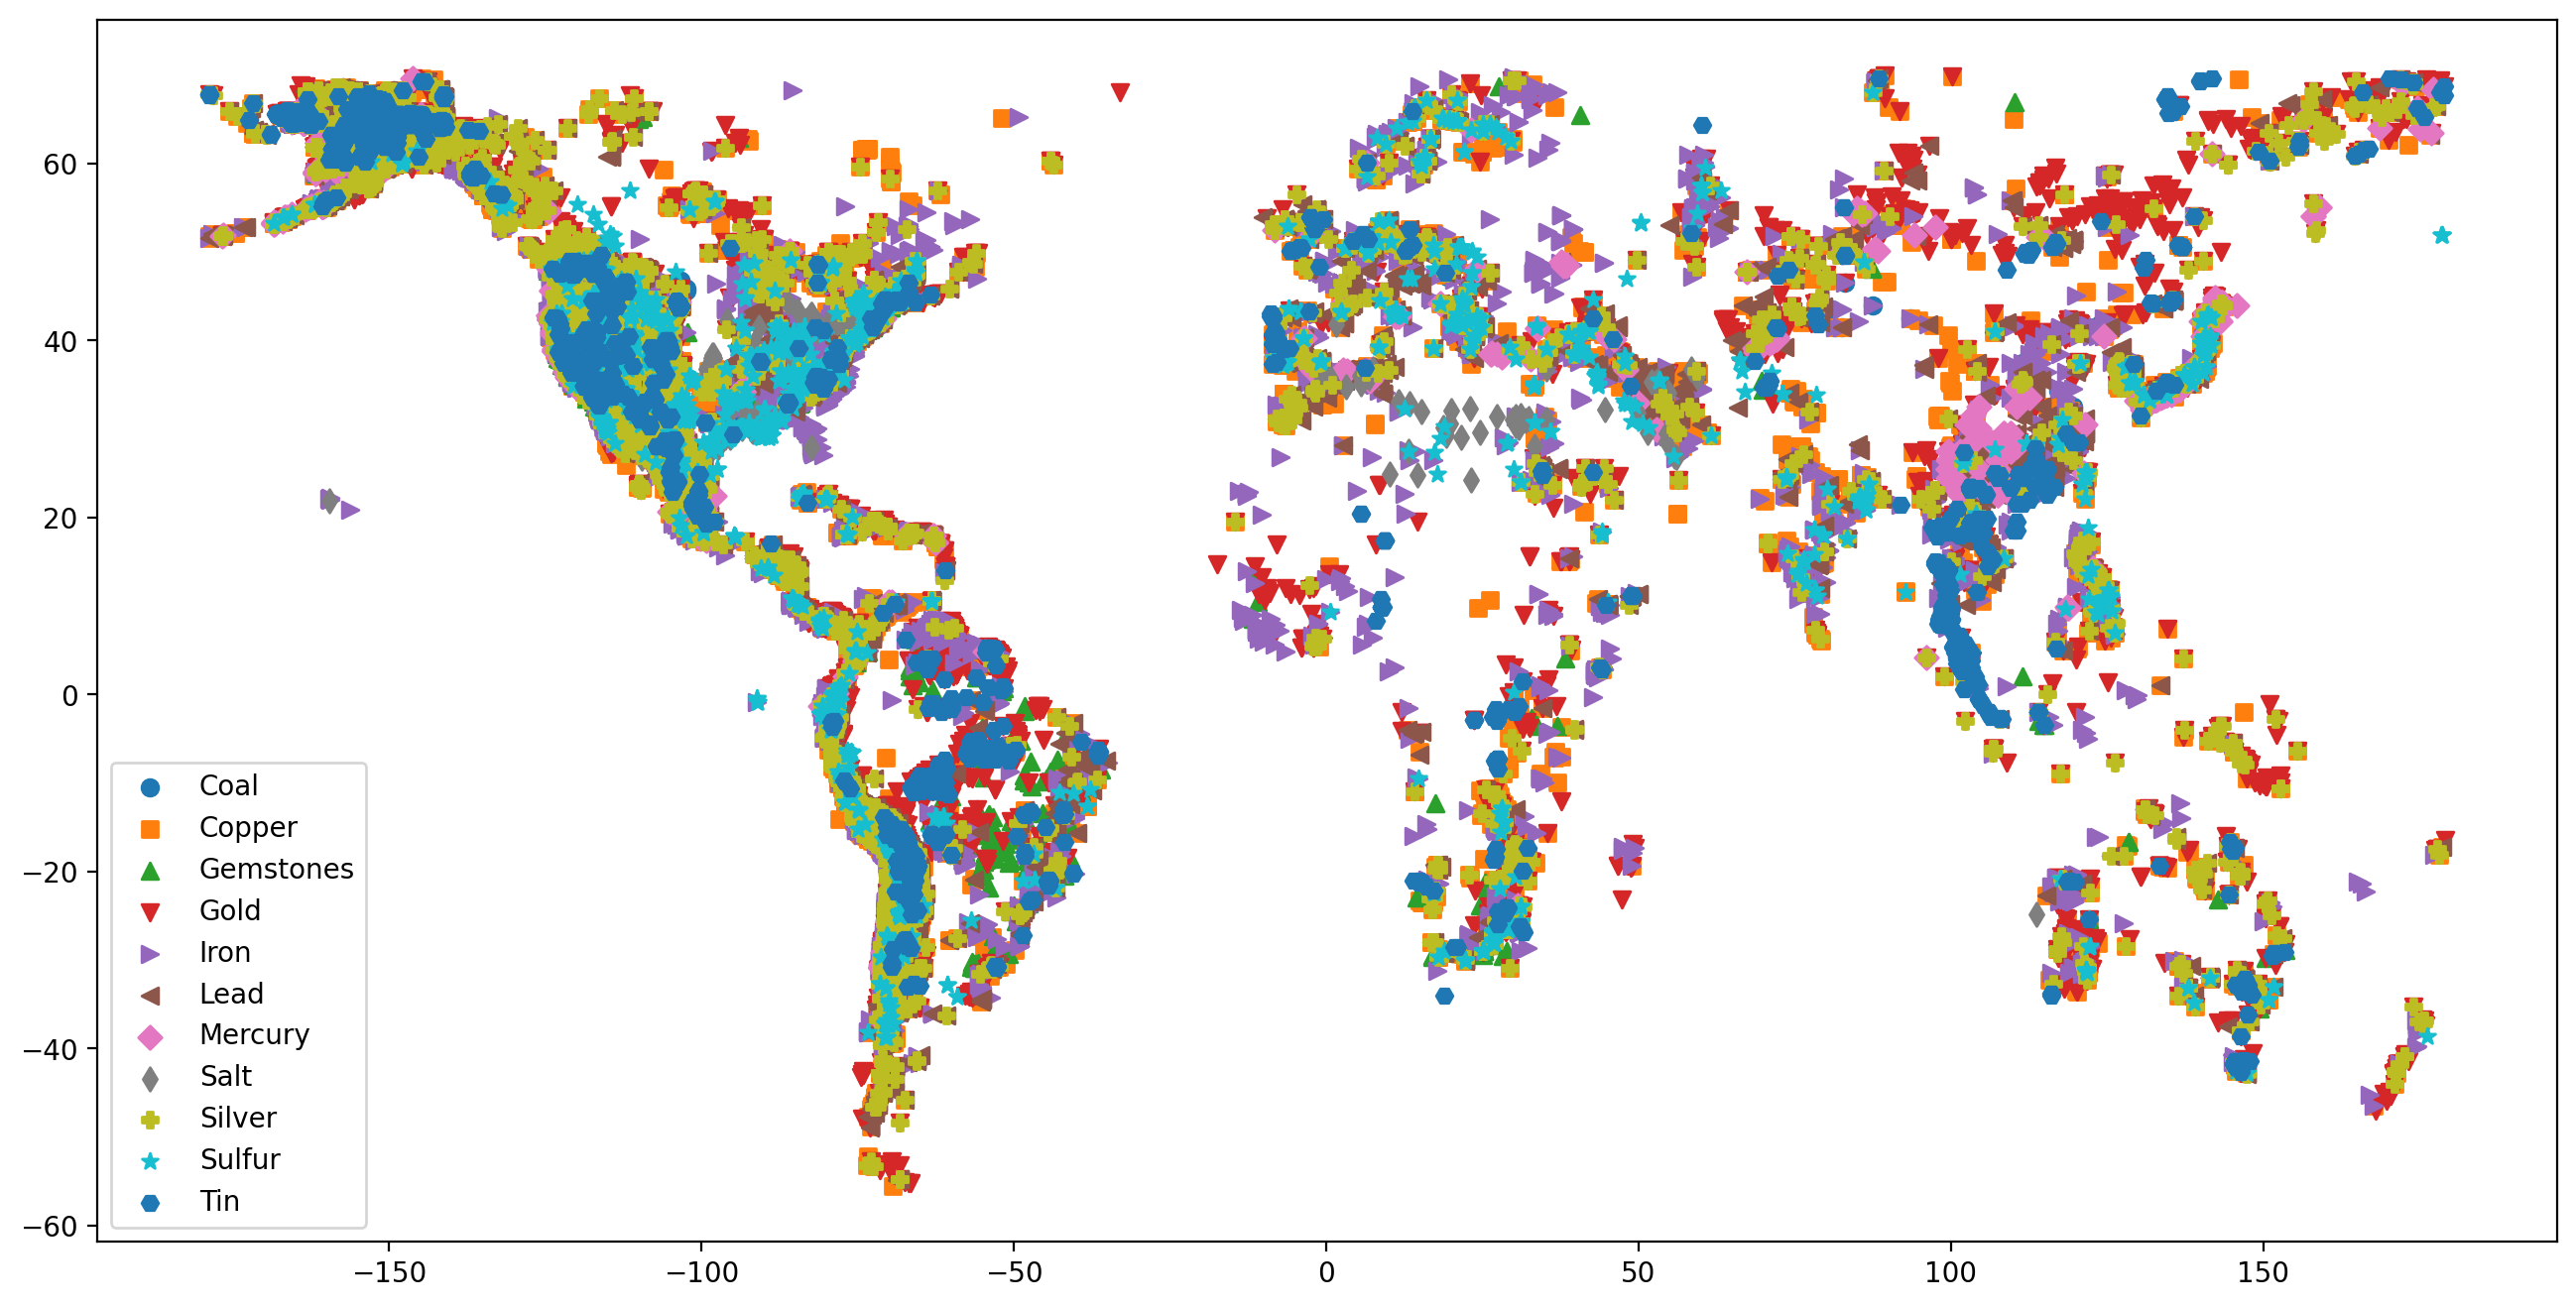

In [105]:
import matplotlib.pyplot as plt

groups = mining.groupby('resource')

plt.figure(figsize=(16,8), dpi=200)
i = 0
markers = ['o', 's', '^', 'v', '>', '<', 'D', 'd', 'P', '*', 'H', 'X']
for name, group in groups:
    plt.scatter(group['lon'], group['lat'], label=name, marker=markers[i])
    i+=1
plt.legend()
plt.savefig('testtttt.png')
plt.show()

In [ ]:
# NOTHING IN THIS DOCUMENT SHOULD BE RUN, OR IT WILL OVERWRITE MANUAL CHANGES IN THE IMAGES
# Used to make the heightmap and wrt the water mask, just the coastline. After that I manually did Holland, Venice. The heightmap also had a couple bugged areas, especially chile
with rasterio.open('inputs/worldClim/elv2.tif') as src:
    # Define the latitude range you want to extract
    min_latitude = -60
    max_latitude = 70
    
    # Get the affine transform and inverse transform
    transform = src.transform
    inv_transform = ~transform

    # Get the row indices corresponding to the latitude range
    _, max_row = inv_transform * (0, min_latitude)
    _, min_row = inv_transform * (0, max_latitude)

    # Define the window to extract the latitude band
    window = rasterio.windows.Window(col_off=0, row_off=min_row, width=src.width, height=max_row - min_row)

    # Read the data from the GeoTIFF file using the specified window
    elv = src.read(1, window=window)

elv += 415
elv[elv<-10000]=0
elv = np.uint8(elv*(255/8424))

Image.fromarray(elv).save('intermediate/elv.png')
# After this I manually resized and more. There was a big chunk of bad data near Chile, fixed using the bathymetry land data

In [30]:
output_transform = from_bounds(-180, -60, 180, 70, 16384, 8192)
output_crs = 'EPSG:4326'

In [28]:
waterPoly = gdp.read_file('inputs/waterpoligons/ne_10m_rivers_lake_centerlines.shp')

waterPoly = waterPoly.dropna(subset='name')

pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 10)
waterPoly.head(2000)

,dissolve,scalerank,featurecla,name,name_alt,rivernum,note,min_zoom,name_en,min_label,ne_id,label,wikidataid,name_ar,name_bn,name_de,name_es,name_fr,name_el,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,name_fa,name_he,name_uk,name_ur,name_zht,geometry
1,976River,9,River,Rungwa,NaN,976,NaN,7.1,Rungwa,8.1,1159128967,Rungwa,Q35311383,رونجوا,রুংওয়া,Rungwa River,Rungwa,Rungwa,Ρούνγκβα,रुंगवा,Rungwa,Rungwa,Rungwa,ルングワ川,룽와,Rungwa,Rungwa,Rungwa,река Рунгва,Rungwa,Rungwa,Sông Rungwa,伦瓜河,رونگوا,רונגווה,Рунгва,رنگوا,倫瓜河,"MULTILINESTRING ((32.00000 -7.24993, 32.02793 ..."
2,977River,9,River,Ligonha,NaN,977,NaN,7.1,Ligonha,8.1,1159128969,Ligonha,NaN,ليجونها,লিগোনহা,Ligonha,Ligonha,Ligonha,Λιγκόνια,लिगोन्हा,Ligonha,Ligonha,Ligonha,リゴンハ川,리고냐,Ligonha,Ligonha,Ligonha,река Лигонья,Ligonha,Ligonha,Sông Ligonha,利戈尼亚河,لیگونها,ליגונה,Лігонха,لیگونہا,利戈尼亞河,"MULTILINESTRING ((39.12783 -16.86663, 39.12598..."
3,978River,9,River,Dongwe,NaN,978,NaN,7.1,Dongwe,8.1,1159128971,Dongwe,NaN,دونغوي,দঙ্গোয়ে,Dongwe,Dongwe,Dongwe,Ντόνγκβε,डोंगवे,Dongwe,Dongwe,Dongwe,ドングウェ川,동웨,Dongwe,Dongwe,Dongwe,река Донгу,Dongwe,Dongwe,Sông Dongwe,松威河,دونگوه,דונגווה,Донгве,ڈانگوے,東威河,"LINESTRING (25.53330 -14.58333, 25.49502 -14.5..."
4,979River,9,River,Cuito,NaN,979,NaN,7.1,Cuito,8.1,1159128973,Cuito,Q1143331,كيتو,কুইটো,Cuito,Cuito,Rio Cuito,Κουίτο,क्यूटो,Cuito,Cuito,Cuito,クイト川,쿠이토,Cuito,Cuito,Cuito,река Квито,Cuito,Cuito,Sông Cuito,奎托河,کیتو,קיטו,Куіто,کیوٹو,奎托河,"MULTILINESTRING ((20.75000 -17.99993, 20.75234..."
7,981River,9,River,Bagoé,NaN,981,NaN,7.1,Bagoé,8.1,1159128995,Bagoé,Q23208733,باجوي,বাগোয়ে,Bagoé,Bagoé,Bagoé,Μπαγκόε,बगोए,Bagoé,Bagoé,Bagoé,バゴエ川,바고에,Bagoé,Bagoé,Bagoé,Багое,Bagoé,Bagoé,Sông Bagoé,巴戈埃河,بگویه,באגואֶה,Багує,بیگئوے,巴戈埃河,"MULTILINESTRING ((-6.94443 9.38886, -6.81089 9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,7River,1,River,Madison,NaN,7,NaN,2.0,Madison,3.0,1159127611,Madison,Q947477,ماديسون,ম্যাডিসন,Madison,Madison,Madison,Μάντισον,मैडिसन,Madison,Madison,Madison,マディソン川,매디슨강,Madison,Madison,Madison,Мадисон,Madison,Madison,Sông Madison,麦迪逊河,مادیسون,מדונה,Медісон,میڈیسن,麥迪遜河,"MULTILINESTRING ((-111.09849 44.75934, -111.08..."
1467,8Lake Centerline,1,Lake Centerline,Missouri,NaN,8,NaN,2.0,Missouri,3.0,1159128475,Missouri,Q5419,نهر ميزوري,মিসৌরি নদী,Missouri,Misuri,Missouri,Μιζούρι,मिसोरी नदी,Missouri,Missouri,Missouri,ミズーリ川,미주리강,Missouri,Missouri,Missouri,Миссури,Missourifloden,Missouri,Missouri,密蘇里河,رودخانه میزوری,מיזורי,Міссурі,دریائے مسوری,密蘇里河,"MULTILINESTRING ((-111.69731 46.66157, -111.68..."
1468,8River,1,River,Missouri,NaN,8,NaN,2.0,Missouri,3.0,1159128481,Missouri,Q5419,نهر ميزوري,মিসৌরি নদী,Missouri,Misuri,Missouri,Μιζούρι,मिसोरी नदी,Missouri,Missouri,Missouri,ミズーリ川,미주리강,Missouri,Missouri,Missouri,Миссури,Missourifloden,Missouri,Missouri,密蘇里河,رودخانه میزوری,מיזורי,Міссурі,دریائے مسوری,密蘇里河,"MULTILINESTRING ((-108.19060 47.60175, -108.24..."
1469,22561Salinas,10,River,Salinas,NaN,22561,Version 1.2 edit in N. America and Europe,7.2,Salinas,8.2,1159114223,Salinas,Q1161673,ساليناس,স্যালিনাস,Salinas,Salinas,Salinas,Σαλίνας,सेलिनास,Salinas,Salinas,Salinas,サリナス川,살리나스,Salinas,Salinas,Salinas,река Салинас,Salinas River,Salinas,Sông Salinas,萨利纳斯河,سالیناس,סאלינאס,Салінас,سالیناس,萨利纳斯河,"LINESTRING (-120.88884 36.00002, -120.85425 35..."


In [ ]:
# Just used for the caspian sea at the moment
waterPoly = gdp.read_file('inputs/waterpoligons/water_polygons.shp')
waterMask = np.zeros((8192, 16384), dtype=np.uint8)

waterPoly = waterPoly.to_crs(output_crs)
waterMask = rasterize(
    waterPoly.geometry,
    out=waterMask,
    transform=output_transform,
    dtype=np.uint8,
    fill=0,
    all_touched=True
)
waterMask[waterMask==1] = 255
Image.fromarray(waterMask).save('intermediate/seaMask.png')

# Lakes from the present day. Some needed work as they have significantly changed since medieval times
waterPoly = gdp.read_file('inputs/waterpoligons/ne_10m_lakes.shp')
waterMask = np.zeros((8192, 16384), dtype=np.uint8)

waterPoly = waterPoly.to_crs(output_crs)
waterMask = rasterize(
    waterPoly.geometry,
    out=waterMask,
    transform=output_transform,
    dtype=np.uint8,
    fill=0,
    all_touched=True
)
waterMask[waterMask==1] = 255
Image.fromarray(waterMask).save('intermediate/lakeMask.png')

# A few like lake Chad or the Aral sea
waterPoly = gdp.read_file('inputs/waterpoligons/ne_10m_lakes_historic.shp')
waterMask = np.zeros((8192, 16384), dtype=np.uint8)

waterPoly = waterPoly.to_crs(output_crs)
waterMask = rasterize(
    waterPoly.geometry,
    out=waterMask,
    transform=output_transform,
    dtype=np.uint8,
    fill=0,
    all_touched=True
)
waterMask[waterMask==1] = 255
Image.fromarray(waterMask).save('intermediate/lakeHistoricMask.png')

In [3]:
# A few like lake Chad or the Aral sea
waterPoly = gdp.read_file('inputs/waterpoligons/ne_10m_rivers_lake_centerlines.shp')
waterMask = np.zeros((8192, 16384), dtype=np.uint8)

waterPoly = waterPoly.to_crs(output_crs)
waterMask = rasterize(
    waterPoly.geometry,
    out=waterMask,
    transform=output_transform,
    dtype=np.uint8,
    fill=0,
    all_touched=True
)
waterMask[waterMask==1] = 255
Image.fromarray(waterMask).save('intermediate/lakeRiverCenterlines.png')

In [5]:
noRiverMask = np.array(Image.open('intermediate/waterNoRivers.png').convert('L'))
riverMask = np.array(Image.open('intermediate/lakeRiverCenterlines.png').convert('L'))
waterMask = np.maximum(noRiverMask, riverMask)

Image.fromarray(waterMask).save('outputs/waterMask.png')

In [6]:
# Smooth coastal transition. Every pixel near water gets the water elevation and also propagates it to its neighbors
waterMask = np.array(Image.open('outputs/waterMask.png').convert('L'))
elv = np.array(Image.open('intermediate/elv.png').convert('L'))

def kernelSmoothCoast(limsy, limsx):
    @cuda.jit
    def paintNear(heightcolor, height, water, posy, posx):
        height[posy, posx] = heightcolor

        # y, x = max(0,posy-1), max(0,posx-1)
        # if water[y,x]==0: height[y,x] = heightcolor
        # y, x = max(0,posy-1), posx
        # if water[y,x]==0: height[y,x] = heightcolor
        # y, x = max(0,posy-1), min(posx+1,limsx-1)
        # if water[y,x]==0: height[y,x] = heightcolor

        # y, x = posy, max(0,posx-1)
        # if water[y,x]==0: height[y,x] = heightcolor
        # y, x = posy, min(posx+1,limsx-1)
        # if water[y,x]==0: height[y,x] = heightcolor

        # y, x = min(posy+1,limsy-1), max(0,posx-1)
        # if water[y,x]==0: height[y,x] = heightcolor
        # y, x = min(posy+1,limsy-1), posx
        # if water[y,x]==0: height[y,x] = heightcolor
        # y, x = min(posy+1,limsy-1), min(posx+1,limsx-1)
        # if water[y,x]==0: height[y,x] = heightcolor

    @cuda.jit
    def f(height, water):
        posy, posx = cuda.grid(2)
        
        if posy < limsy and posx < limsx: # Must have or crashes out of bounds
            if water[posy, posx]==255: return

            y, x = max(0,posy-1), max(0,posx-1)
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return
            y, x = max(0,posy-1), posx
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return
            y, x = max(0,posy-1), min(posx+1,limsx-1)
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return

            y, x = posy, max(0,posx-1)
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return
            y, x = posy, min(posx+1,limsx-1)
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return
            
            y, x = min(posy+1,limsy-1), max(0,posx-1)
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return
            y, x = min(posy+1,limsy-1), posx
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return
            y, x = min(posy+1,limsy-1), min(posx+1,limsx-1)
            if water[y,x]==255: 
                paintNear(height[y,x], height, water, posy, posx)
                return

    return f

def smoothCoastGPU(elv, waterMask):
    limsy, limsx = elv.shape

    gpuHeight = cuda.to_device(np.uint8(elv))
    gpuWater = cuda.to_device(np.uint8(waterMask))

    threadsperblock = (16, 16)
    blockspergridy = np.ceil(limsy / threadsperblock[0]).astype(np.int32)
    blockspergridx = np.ceil(limsx / threadsperblock[1]).astype(np.int32)
    blockspergrid = (blockspergridy, blockspergridx)

    kernelSmoothCoast(limsy, limsx)[blockspergrid, threadsperblock](gpuHeight, gpuWater)
    heightmap = gpuHeight.copy_to_host()

    return heightmap

heightmap = smoothCoastGPU(elv, waterMask)
Image.fromarray(heightmap).save('outputs/heightmap.png')

In [29]:
with rasterio.open('inputs/bathymetry/ETOPO2022bedrock.tif') as src:
    # Define the latitude range you want to extract
    min_latitude = -60
    max_latitude = 70
    
    # Get the affine transform and inverse transform
    transform = src.transform
    inv_transform = ~transform

    # Get the row indices corresponding to the latitude range
    _, max_row = inv_transform * (0, min_latitude)
    _, min_row = inv_transform * (0, max_latitude)

    # Define the window to extract the latitude band
    window = rasterio.windows.Window(col_off=0, row_off=min_row, width=src.width, height=max_row - min_row)

    # Read the data from the GeoTIFF file using the specified window
    bathymetry = src.read(1, window=window)

bathymetry[bathymetry>0] *= (127/8157)
bathymetry[bathymetry>0] += 1
bathymetry[bathymetry<0] *= (127/10752)
bathymetry += 127
bathymetry = np.uint8(bathymetry)
bathymetry = np.array(Image.fromarray(bathymetry).resize((16384,8192), Image.Resampling.LANCZOS))

waterMask = np.array(Image.open('intermediate/seaMask.png').convert('L'))
bathymetry[(waterMask==255) & (bathymetry > 126)] = 126
bathymetry[(waterMask==0) & (bathymetry < 127)] = 127

Image.fromarray(bathymetry).save('intermediate/bathymetry.png')

In [10]:
# popdensity = np.array(GeoTiff('inputs/popdensity/gpw_ciesin_columbia.tif').read(), dtype=np.float32)[2399:17999,:]

# popdensity[popdensity<0] = -1
# popdensity[popdensity<1] += 1
# popdensity[popdensity>310] = 310

# im = Image.fromarray(np.uint8(popdensity/np.max(popdensity)*255)).resize((512, 256), Image.Resampling.LANCZOS)
# im.show()
# im.save('intermediate/lowresPopdensity.png')

In [3]:
with open('inputs/popdensity/popd_1200AD.asc', 'r') as file:
    # Read the header information
    ncols = int(file.readline().split()[1])
    nrows = int(file.readline().split()[1])
    xllcorner = float(file.readline().split()[1])
    yllcorner = float(file.readline().split()[1])
    cellsize = float(file.readline().split()[1])
    nodata_value = float(file.readline().split()[1])

    print(ncols, nrows, xllcorner, yllcorner, cellsize, nodata_value)

    # Read the raster data into a 2D array
    popdensity = np.array([[float(x) for x in line.split()] for line in file])[240:1800,:]

popdensity[popdensity<0] = 0
popdensity[popdensity>18] = 18

im = Image.fromarray(np.uint8(popdensity/np.max(popdensity)*255)).resize((16384, 8192), Image.Resampling.LANCZOS)
im.save('intermediate/popdensity.png')

im = Image.fromarray(np.uint8(popdensity/np.max(popdensity)*255)).resize((1024, 512), Image.Resampling.LANCZOS)
im.show()
im.save('intermediate/lowresPopdensity.png')

4320 2160 -180.0 -90.0 0.0833333 -9999.0
